# Identifying High-Engagement Player Segments Through Demographic and Behavioral Analysis

**Authors:**  
- Kehan Hettiarachchi  
- Kenshin Tanaka  
- Caio Matos  
- Finley Bradshaw  

**Date:** April 5, 2025

## Introduction

Understanding which players contribute the most in-game data is essential for making informed decisions in game design, user retention, and personalized content strategies. This project aims to identify player characteristics that are strongly linked to high engagement, which we measure by total hours played. Engagement is a key performance indicator in gaming; players who spend more time in-game generally provide more interaction data, are more likely to convert to paid services, and can serve as valuable participants in beta testing or early feature releases.

The central question guiding this report is:  
**Can we use player attributes such as age, experience level and subscription status to predict how many hours a player will play?**

We will explore this by utilizing a dataset called `players.csv`, which contains **196 player records** and **seven variables**: `experience`, `subscribe`, `hashedEmail`, `played_hours`, `name`, `gender`, and `age`. This dataset seems to be collected from an online platform and includes both **numeric variables** (such as `played_hours` and `age`) and **categorical fields** (such as `experience`, `subscribe`, and `gender`) that provide insights into player demographics and behavior.


### Dataset Overview

- **Played hours** is the main target variable, ranging from 0 to 223.1 hours. It has a mean of **5.85** and a median of **0**, which indicates a highly skewed distribution with outliers.

- **Participant ages** range from **8 to 50 years**, with a mean of approximately **20.5** and a median of **19**. Two entries are missing from the dataset.

- **Experience** is divided into five levels:
  - Amateur (32%)
  - Beginner (3%)
  - Pro (7%)
  - Regular (22%)
  - Veteran (36%)

- **Subscribe** is mostly `TRUE` (~73%), indicating a high subscription rate.

- **Gender demographics** include:
  - Male (63%)
  - Female (19%)
  - Non-binary (12%)
  - A few minor categories grouped under `"Other"`
  - Not included in the analysis as there are too many different genders to account for.

- `hashedEmail` and `name` serve as **unique identifiers** and are not utilized in the analysis.

### Rationale

Identifying high-engagement players offers both analytical and business value. From an analytical perspective, understanding how various factors relate to playtime can help optimize predictive models. For business or design teams, knowing who the most active players are can support targeted marketing campaigns, loyalty programs, and content customization.

However, there are potential modeling challenges to consider:
- **Outliers** in `played_hours`, where many players have recorded 0 hours while a small number play extensively.
- **Low-frequency categories** in `experience` and `subscription`, which can compromise the reliability of results for smaller groups.

This project utilizes **Jupyter Notebook** to execute the complete analysis pipeline: loading and cleaning data, performing exploratory data analysis (EDA), and applying regression techniques to model playtime based on demographic attributes. Every aspect of this process is designed to be fully reproducible and understandable for both technical and non-technical audiences.

By the end of this report, we aim to provide actionable insights and a functioning model that highlights the characteristics of the players who are most engaged with the game. These insights can inform recruiting strategies for data collection, enhance retention efforts, and aid in game personalization initiatives.


To use the attributes of experience, being subscribed to a related gaming news letter and age to try and predict hours played, we will be using a k-nn regression model. As the attributes do not have an identified linear relationship with hours played, we will be using a k-nn regression model as this model does not need any specific relationship between the data. To be able to use the k-nn regression model, the values in the experience column and the subscribe column were altered. The experience column values have been changed to the according: 
Beginner = 1 
Amateur = 2 
Regular = 3 
Pro = 4 
Veteran = 5 
The subscribe column has been changed to the according: 
False = 1 
True = 2 
This way we can use these attributes in the k-nn regression model as this model predicts a numeric value and to do this all our predictors need to be a numeric value. 

In [1]:
set.seed(1)
library(tidyverse) 
library(janitor)
library(readr) 
library(dplyr) 
library(stringr) 
library(GGally)
library(ISLR) 
library(repr) 
library(tidymodels)
url <- "https://raw.githubusercontent.com/FinBradshaw/Proposal-Planning/refs/heads/main/players.csv"
players <- read_csv(url)  
players <- players |> 
 tibble() |>
 clean_names() |>
filter(!is.na(age)) |> 
select(experience, subscribe, played_hours, age) |>
mutate(experience = recode(experience, Beginner = 1, Amateur = 2, Regular = 3, Pro = 4, Veteran = 5)) |> 
mutate(subscribe = as.character(subscribe)) |>
mutate(subscribe = recode(subscribe, "TRUE" = 2, "FALSE" = 1))

players_split <- initial_split(players, prop = 0.75, strata = played_hours)  
players_train <- training(players_split) 
players_test <- testing(players_split) 

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
set_engine("kknn") |> 
set_mode("regression") 

players_recipe <- recipe(played_hours ~ experience + subscribe + age, data = players_train) |> 
step_scale(all_predictors()) |> 
step_center(all_predictors())  

players_vfold <- vfold_cv(players_train, v = 5, strata = played_hours) 

players_workflow <- workflow() |> 
add_recipe(players_recipe) |> 
add_model(players_spec)  

gridvals <- tibble(neighbors = seq(from = 1, to = 106, by = 5)) 

players_results <- players_workflow |> 
tune_grid(resamples = players_vfold, grid = gridvals) |> 
collect_metrics() 

players_min <- players_results |> 
filter(.metric == "rmse") |> 
slice_min(mean, n = 1) 

players_min











── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip  

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
21,rmse,standard,28.55692,5,6.690528,Preprocessor1_Model05


As viewed the the minumum mean of the rmse occurs when k = 21. So, we will use k = 21 in our k-nn regression model.  

In [6]:
neighbor_num <- players_min|> 
               pull(neighbors)
players_spec_k <- nearest_neighbor(weight_func = "rectangular", neighbors = neighbor_num) |> 
set_engine("kknn") |> 
set_mode("regression") 

players_fit <- workflow() |>
         add_recipe(players_recipe) |>
         add_model(players_spec_k) |>
         fit(data = players_train)

players_summary <- players_fit |>
          predict(players_test) |>
          bind_cols(players_test) |>
          metrics(truth = played_hours, estimate = .pred)
players_summary


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,14.40708104
rsq,standard,0.00233459
mae,standard,9.08911565


With our model was able to predict the hours played +/- of 14.4 hours of the actual value in our testing set. This is quite a big +/- considering most of the hours played are below 10 hours. This is caused by the few outliers who have a lot more hours played than the average person.  

In [7]:

new_observation1 <- tibble(experience = 3, subscribe = 2, age = 22) 
new_observation2 <- tibble(experience = 5, subscribe = 1, age = 45) 
new_observation3 <- tibble(experience = 2, subscribe = 2, age = 15) 
new_observation4 <- tibble(experience = 3, subscribe = 1, age = 22) 
predicted_hours <- predict(players_fit, new_observation1) 
predicted_hours1 <- predict(players_fit, new_observation2) 
predicted_hours2 <- predict(players_fit, new_observation3) 
predicted_hours3 <- predict(players_fit, new_observation4) 
predicted_hours 
predicted_hours1 
predicted_hours2 
predicted_hours3

.pred
<dbl>
23.28095


.pred
<dbl>
1.985714


.pred
<dbl>
13.10476


.pred
<dbl>
0.3714286


Viewed above, the model does work and indeed can predict how many hours a players may play based on the outlined attributes. 

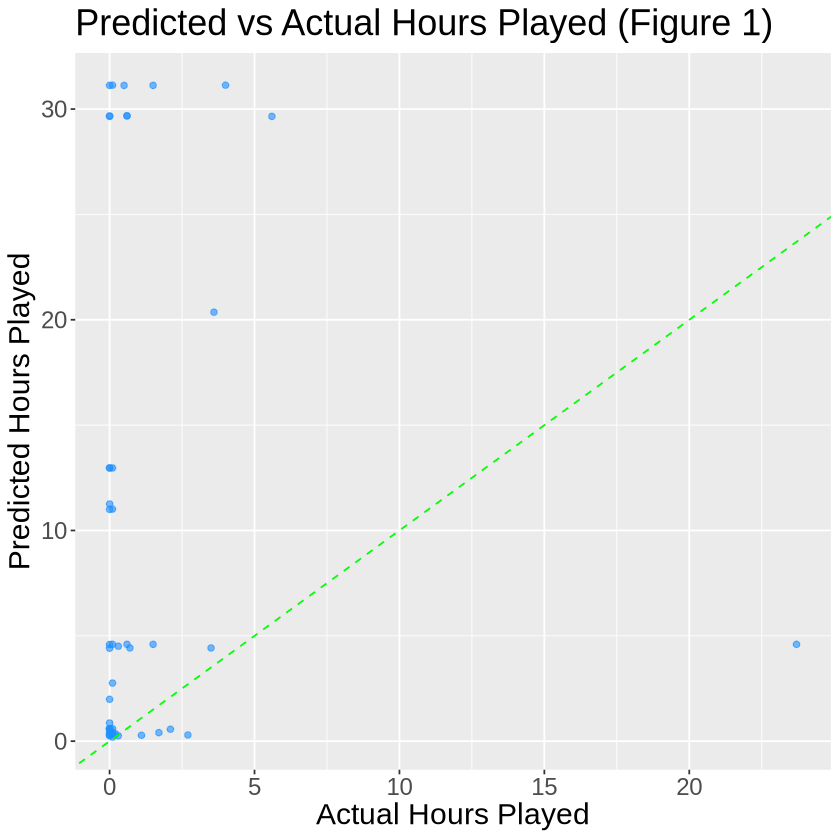

In [26]:
players_predicted <- players_fit |>
          predict(players_test) |>
          bind_cols(players_test)  

predicted_vs_actual <- players_predicted |>
ggplot(aes(x = played_hours, y = .pred,)) + 
        geom_point(alpha = 0.6, color = "dodgerblue") +
  geom_abline(slope = 1, intercept = 0, color = "green", linetype = "dashed") +
  labs(title = "Predicted vs Actual Hours Played (Figure 1)", x = "Actual Hours Played", y = "Predicted Hours Played")+ 
theme(text = element_text(size = 18))
predicted_vs_actual

The closer the dots are to the center line means the closer the prediction was to the actual value. Here we can see that it is a little hard to accurately predict time played as there are not many points near the center line. 